# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Out-of-Core-computation" data-toc-modified-id="Out-of-Core-computation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Out-of-Core computation</a></div><div class="lev2 toc-item"><a href="#Handling-large-grids" data-toc-modified-id="Handling-large-grids-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Handling large grids</a></div><div class="lev2 toc-item"><a href="#Opening-multiple-netCDF-files,-and-using-Dask" data-toc-modified-id="Opening-multiple-netCDF-files,-and-using-Dask-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Opening multiple netCDF files, and using Dask</a></div><div class="lev2 toc-item"><a href="#Chunking-and-performance" data-toc-modified-id="Chunking-and-performance-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Chunking and performance</a></div><div class="lev2 toc-item"><a href="#Optimization-Tips" data-toc-modified-id="Optimization-Tips-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Optimization Tips</a></div><div class="lev2 toc-item"><a href="#Key-Points" data-toc-modified-id="Key-Points-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Key Points</a></div>

# Out-of-Core computation


## Handling large grids
When xarray carries out processing on an array it must load it into memory. Many datasets are becoming too large for this to be carried out on a typical laptop. For this reason, xarray integrates with a parallel computing library called Dask. Dask uses task scheduling and blocked algorithms to enable processing of datasets that “fit on disk” even if they do not “fit in memory”.

Dask:
- dask.array = numpy + threading
- dask.bag = map, filter, toolz + multiprocessing
- dask.dataframe = pandas + threading

![](http://dask.pydata.org/en/latest/_images/collections-schedulers.png)

![](http://mrocklin.github.com/blog/images/dask/embarrassing.gif)

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn')
matplotlib.rcParams['figure.figsize'] = (12, 15)
import numpy as np
import pandas as pd
import seaborn as sns
import holoviews as hv
import geoviews as gv
import geoviews.feature as gf
import xarray as xr
from cartopy import crs

hv.notebook_extension()

## Opening multiple netCDF files, and using Dask

We will use the mfdataset option that opens multiple files as a single xarray dataset. This automatically invokes the dask functionality:

In [3]:
ds = xr.open_mfdataset('/home/abanihi/Documents/climate-data/NCEP-OI/*.nc', chunks={'time':10}, autoclose=True)

In [4]:
ds

<xarray.Dataset>
Dimensions:   (lat: 89, lon: 180, nv: 2, time: 1956, zlev: 1)
Coordinates:
  * zlev      (zlev) float32 0.0
  * lat       (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 ...
  * lon       (lon) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 ...
  * time      (time) datetime64[ns] 1854-01-15 1854-02-15 1854-03-15 ...
Dimensions without coordinates: nv
Data variables:
    lat_bnds  (time, lat, nv) float32 -89.0 -87.0 -87.0 -85.0 -85.0 -83.0 ...
    lon_bnds  (time, lon, nv) float32 -1.0 1.0 1.0 3.0 3.0 5.0 5.0 7.0 7.0 ...
    sst       (time, zlev, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    anom      (time, zlev, lat, lon) float64 nan nan nan nan nan nan nan nan ...
Attributes:
    Conventions:                CF-1.6
    Metadata_Conventions:       CF-1.6, Unidata Dataset Discovery v1.0
    metadata_link:              C00884
    id:                         ersst.v4.185401
    naming_authority:           gov.noaa.ncdc
    title:          

## Chunking and performance
Without specifying chunk size, open_mfdataset chunks along existing dimensions. Getting the chunk size right is the crucial step to optimize working with xarray/dask. 


The chunks parameter has critical performance implications when using dask arrays. If your chunks are too small, queueing up operations will be extremely slow, because dask will translates each operation into a huge number of operations mapped across chunks. Computation on dask arrays with small chunks can also be slow, because each operation on a chunk has some fixed overhead from the Python interpreter and the dask task executor.

Conversely, if your chunks are too big, some of your computation may be wasted, because dask only computes results one chunk at a time.

A good rule of thumb to create arrays with a minimum chunksize of at least one million elements (e.g., a 1000x1000 matrix). With large arrays (10+ GB), the cost of queueing up dask operations can be noticeable, and you may need even larger chunksizes.

You should use chunk sizes of about 1 million elements. In our case: 480* 241 = 115680, so make the time chunk 10 to get around 1 million. Note that we are only chunking the time dimension. Choice depends on how you will be working with the data.

Now when can carry out any processes on the Dataset, dask will be invoked. It is wise to include the ProgressBar tool from dask.diagnostics to track the processing:

[########################################] | 100% Completed |  7.8s
CPU times: user 9.91 s, sys: 1.47 s, total: 11.4 s
Wall time: 9.71 s


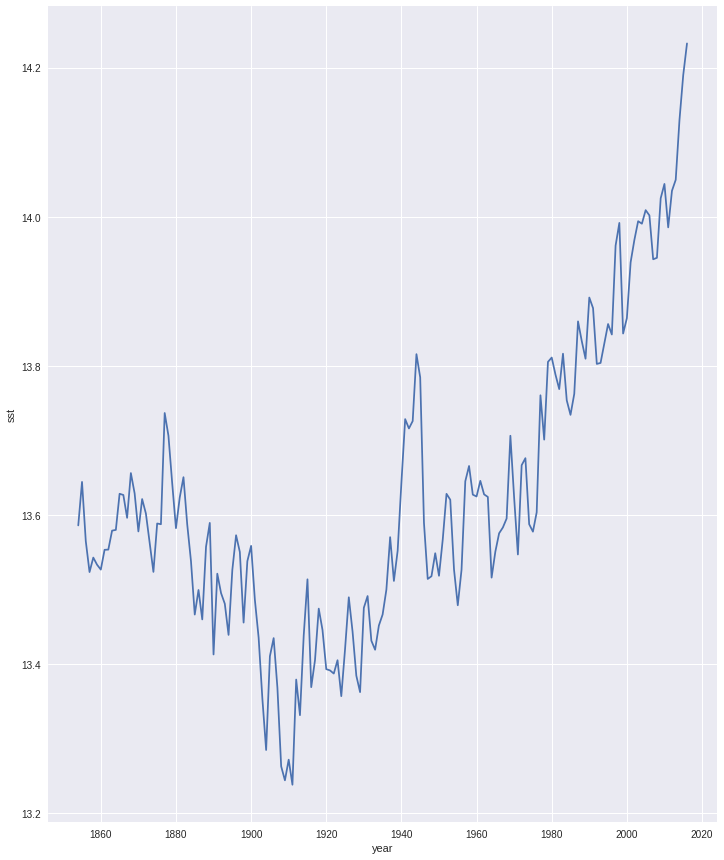

In [6]:
from dask.diagnostics import ProgressBar
with ProgressBar():
  %time ds.sst.groupby('time.year').mean().plot()

## Optimization Tips
With analysis pipelines involving both spatial subsetting and temporal resampling, dask performance can become very slow in certain cases. Here are some optimization tips we have found through experience:

1. Do your spatial and temporal indexing (e.g. ```.sel()``` or ```.isel()```) early in the pipeline, especially before calling ```resample()``` or ```groupby()```. Grouping and rasampling triggers some computation on all the blocks, which in theory should commute with indexing, but this optimization hasn’t been implemented in dask yet. (See dask issue [#746](https://github.com/dask/dask/issues/746)).
2. Save intermediate results to disk as a netCDF files (using ```to_netcdf()```) and then load them again with ```open_dataset()``` for further computations. For example, if subtracting temporal mean from a dataset, save the temporal mean to disk before subtracting. Again, in theory, dask should be able to do the computation in a streaming fashion, but in practice this is a fail case for the dask scheduler, because it tries to keep every chunk of an array that it computes in memory. (See dask issue [#874](https://github.com/dask/dask/issues/874))
3. Specify smaller chunks across space when using ```open_mfdataset()``` (e.g., ```chunks={'latitude': 10, 'longitude': 10}```). This makes spatial subsetting easier, because there’s no risk you will load chunks of data referring to different chunks (probably not necessary if you follow suggestion 1).



## Key Points

- dask integration with xarray allows you to work with large datasets that “fit on disk” rather than having to “fit in memory”.
- It is important to chunk the data correctly for this to work.
